### Baseline модель для определения именованных сущностей по кейсу от Rutube.
Поскольку нам нужно распознать нестандартные NER, можно воспользоваться помощью языковых моделей, в данном случае - Bert.
Данные вы уже получили  - это разметка, сделанная на Толоке, она не идеальна, но это часть практической задачи, с которой можно столкнуться в реальности.

Небольшое введение в NER https://habr.com/ru/companies/contentai/articles/449514/

In [47]:
# считаем данные
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm.notebook import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

data = pd.read_csv("data/train_data/ner_data_train.csv")

In [2]:
data.head(5)

,video_info,entities
0,<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Р...,"{""label"":""локация""\,""offset"":26\,""length"":6\,""..."
1,<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 V...,"{""label"":""организация""\,""offset"":196\,""length""..."
2,<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Челов...,"{""label"":""название проекта""\,""offset"":12\,""len..."
3,<НАЗВАНИЕ:> Довоенная немецкая кирха в Калинин...,"{""label"":""не найдено""\,""offset"":162\,""length"":..."
4,"<НАЗВАНИЕ:> ""Спартаку"" помогли судьи? Локомоти...","{""label"":""команда""\,""offset"":13\,""length"":8\,""..."


In [3]:
# данные спарсены с Толоки, поэтому могут иметь проблемы с символами и их нужно избежать,
# удалить лишние '\' например, преобразовать из str в список dict-ов
import json
df = data.copy()
df['entities'] = df['entities'].apply(lambda l: l.replace('\,', ',')if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: l.replace('\\\\', '\\')if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: '[' + l + ']'if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: json.loads(l)if isinstance(l, str) else l)

In [4]:
df.head(3)

,video_info,entities
0,<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Р...,"[{'label': 'локация', 'offset': 26, 'length': ..."
1,<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 V...,"[{'label': 'организация', 'offset': 196, 'leng..."
2,<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Челов...,"[{'label': 'название проекта', 'offset': 12, '..."


#### Оригинал туториала на медицинских данных можно посмотреть тут https://gist.github.com/avidale/cacf235aebeaaf4c578389e1146c3c57

In [79]:
# %pip install razdel transformers datasets seqeval

In [5]:
# Теперь из наших данных нам нужно извлечь для каждого слова (токена) его тег (label) из разметки, чтобы потом предать в модель классификации токенов
from razdel import tokenize

def extract_labels(item):

    # воспользуемся удобным токенайзером из библиотеки razdel,
    # она помимо разбиения на слова, сохраняет важные для нас числа - начало и конец слова в токенах

    raw_toks = list(tokenize(item['video_info']))
    words = [tok.text for tok in raw_toks]
    # words = item['video_info']
    # присвоим для начала каждому слову тег 'О' - тег, означающий отсутствие NER-а
    word_labels = ['O'] * len(raw_toks)
    char2word = [None] * len(item['video_info'])
    # так как NER можем состаять из нескольких слов, то нам нужно сохранить эту инфорцию
    for i, word in enumerate(raw_toks):
        char2word[word.start:word.stop] = [i] * len(word.text)

    labels = item['entities']
    if isinstance(labels, dict):
        labels = [labels]
    if labels is not None:
        for e in labels:
            if e['label'] != 'не найдено':
                e_words = sorted({idx for idx in char2word[e['offset']:e['offset']+e['length']] if idx is not None})
                if e_words:
                    word_labels[e_words[0]] = 'B-' + e['label']
                    for idx in e_words[1:]:
                        word_labels[idx] = 'I-' + e['label']
                else:
                    continue
            else:
                continue
        return {'tokens': words, 'tags': word_labels}
    else: return {'tokens': words, 'tags': word_labels}

In [6]:
print(extract_labels(df.iloc[0]))

{'tokens': ['<', 'НАЗВАНИЕ', ':', '>', 'Агент', '117', ':', 'Из', 'Африки', 'с', 'любовью', '—', 'Русский', 'тизер', '=', 'трейлер', '(', '2021', ')', '<', 'ОПИСАНИЕ', ':', '>', 'Лучший', 'Telegram', 'канал', 'о', 'кино', '<', 'LINK', '>', 'Сотрудничество', '<', 'LINK', '>', 'Дата', 'выхода', '26', 'августа', '2021', 'Оригинальное', 'название', ':', 'OSS', '117', ':', 'Alerte', 'rouge', 'en', 'Afrique', 'noire', 'Страна', ':', 'Франция', 'Режиссер', ':', 'Николя', 'Бедос', 'Жанр', ':', 'боевик', ',', 'комедия', 'В', 'главных', 'ролях', ':', 'Жан', 'Дюжарден', ',', 'Пьер', 'Нинэ', ',', 'Мелоди', 'Каста', ',', 'Наташа', 'Линдинжер', ',', 'Владимир', 'Иорданов', ',', 'Фату', 'Н', '’', 'Диайе', ',', 'Пол', 'Уайт', 'Мир', 'изменился', '.', 'Он', 'нет', '.', 'Судьба', 'заносит', 'легендарного', 'Агента', '117', 'в', 'Африку', ',', 'где', 'горячее', 'пустыни', 'только', 'женщины', '.', 'Вооруженный', 'неиссякаемой', 'уверенностью', 'в', 'себе', 'и', 'убийственной', 'харизмой', ',', 'он', 'мож

### Обработаем датасет и разобьем на трейн и тест

In [7]:
from sklearn.model_selection import train_test_split
ner_data = [extract_labels(item) for i, item in df.iterrows()]
ner_train, ner_test = train_test_split(ner_data, test_size=0.2, random_state=1)

In [8]:
import pandas as pd
pd.options.display.max_colwidth = 300
pd.DataFrame(ner_train).sample(3)

,tokens,tags
3523,"[<, НАЗВАНИЕ, :, >, Сексуальная, жизнь, студенток, /, The, Sex, Lives, of, College, Girls, (, 2021, ), Русский, трейлер, <, ОПИСАНИЕ, :, >, В, центре, истории, —, первокурсницы, колледжа, в, Эссексе, ,, чья, взрослая, жизнь, только, начинается, ., У, каждой, свой, яркий, характер, ,, поэтому, э...","[O, O, O, O, B-название проекта, I-название проекта, I-название проекта, I-название проекта, I-название проекта, I-название проекта, I-название проекта, I-название проекта, I-название проекта, I-название проекта, O, O, O, B-название проекта, I-название проекта, O, O, O, O, O, O, O, O, O, O, O, B..."
54,"[<, НАЗВАНИЕ, :, >, Самая, =, самая, тушенка, ., Доброе, утро, ., Суббота, ., Фрагмент, выпуска, от, 22.02.2020, <, ОПИСАНИЕ, :, >, Тушенка, главная, еда, военных, ,, поисковиков, ,, туристов, ., Чем, полезна, тушенка, и, как, ее, готовят, ?, Когда, этот, продукт, появился, в, России, ?, И, как,...","[O, O, O, O, O, O, O, O, O, B-название проекта, I-название проекта, O, O, O, O, O, O, B-Дата, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-локация, O, O, O, O, O, O, O, O, O, O]"
1805,"[<, НАЗВАНИЕ, :, >, Последний, довод, 1, =, 2, серия, ., Мелодрама, 2022, на, ТВЦ, ., Дата, выхода, =, сюжет, <, ОПИСАНИЕ, :, >, Премьера, 2022, "", Последний, довод, "", 1, 2, серии, обзор, ., Дата, выхода, на, ТВЦ, ., Главные, роли, исполнят, :, Надежда, Борисова, ,, Петар, Зекавица, ,, Сергей, ...","[O, O, O, O, B-название проекта, I-название проекта, B-серия, I-серия, I-серия, I-серия, O, O, B-Дата, O, O, O, O, O, O, O, O, O, O, O, O, B-Дата, O, B-название проекта, I-название проекта, O, B-серия, I-серия, I-серия, O, O, O, O, O, O, O, O, O, O, O, B-персона, I-персона, O, B-персона, I-персо..."


#### Посмотрим на получившиеся теги
Подробнее почитать про BIO теги можно тут https://datascience.stackexchange.com/questions/63399/what-is-bio-tags-for-creating-custom-ner-named-entity-recognization

In [9]:
label_list = sorted({label for item in ner_train for label in item['tags']})
if 'O' in label_list:
    label_list.remove('O')
    label_list = ['O'] + label_list
label_list

['O',
 'B-Дата',
 'B-бренд',
 'B-вид спорта',
 'B-видеоигра',
 'B-команда',
 'B-лига',
 'B-локация',
 'B-модель',
 'B-название проекта',
 'B-организация',
 'B-персона',
 'B-сезон',
 'B-серия',
 'I-Дата',
 'I-бренд',
 'I-вид спорта',
 'I-видеоигра',
 'I-команда',
 'I-лига',
 'I-локация',
 'I-модель',
 'I-название проекта',
 'I-организация',
 'I-персона',
 'I-сезон',
 'I-серия']

In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:
labels_to_ids = {v:k for k,v in enumerate(label_list)}
ids_to_labels = {k:v for k,v in enumerate(label_list)}

In [12]:
class NERDataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len=512):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        tokens = self.data.tokens[index]
        word_labels = self.data.tags[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        tokenized_inputs = self.tokenizer(tokens, truncation=True,
                                     is_split_into_words=True,
                                     padding='max_length',
                                     max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        # pdb.set_trace()
        labels = [labels_to_ids[label] for label in word_labels]
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        # print(len(sentence), len(labels))

        word_ids = tokenized_inputs.word_ids()
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(labels[word_idx])
            previous_word_idx = word_idx

        label_ids = [label_list.index(idx) if isinstance(idx, str) else idx for idx in label_ids]

        item = {key: torch.as_tensor(val) for key, val in tokenized_inputs.items()}
        item['labels'] = torch.as_tensor(label_ids)

        return item

  def __len__(self):
        return self.len

### Запустим модель RuBert-tiny - классический Bert, поверх которого навешен слой классификации токенов.

In [48]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, BertModel
from datasets import load_metric

In [14]:
# model_checkpoint = "ai-forever/ruBert-base"
model_checkpoint = "cointegrated/rubert-tiny"

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, device=device)

In [18]:
ner_train[0]

{'tokens': ['<',
  'НАЗВАНИЕ',
  ':',
  '>',
  'ТОП',
  '=',
  '5',
  'хороших',
  'видеорегистраторов',
  'с',
  'двумя',
  'камерами',
  '.',
  'Что',
  'выбрать',
  'в',
  '2022',
  '?',
  '<',
  'ОПИСАНИЕ',
  ':',
  '>',
  '5',
  '.',
  'Roadgid',
  'Blick',
  'GPS',
  ':',
  '<',
  'LINK',
  '>',
  '4',
  '.',
  'iBOX',
  'iCON',
  'LV',
  'WiFi',
  'Signature',
  'Dual',
  ':',
  '<',
  'LINK',
  '>',
  '3.',
  '70',
  'mai',
  'Dash',
  'Cam',
  'Pro',
  'Plus',
  ':',
  '<',
  'LINK',
  '>',
  '2',
  '.',
  'Daocam',
  'Combo',
  '2',
  'CH',
  ':',
  '<',
  'LINK',
  '>',
  '1',
  '.',
  'RoadGid',
  'CityGo',
  '3',
  '2',
  'CH',
  ':',
  '<',
  'LINK',
  '>',
  'Мы',
  'Вконтакте',
  ':',
  '<',
  'LINK',
  '>',
  'Мы',
  'в',
  'Telegram',
  ':',
  '<',
  'LINK',
  '>',
  'Наш',
  'канал',
  'на',
  'Я',
  '.',
  'Дзен',
  ':',
  '<',
  'LINK',
  '>',
  'Мы',
  'в',
  'ТикТок',
  ':',
  '<',
  'LINK',
  '>',
  '/',
  '<',
  'AT',
  '>',
  'Сотрудничество',
  'и',
  'реклам

In [16]:
train_set = NERDataset(pd.DataFrame(ner_train), tokenizer=tokenizer)
test_set = NERDataset(pd.DataFrame(ner_test), tokenizer=tokenizer)

print("FULL Dataset: {}".format(len(ner_train) + len(ner_test)))
print("TRAIN Dataset: {}".format(len(ner_train)))
print("TEST Dataset: {}".format(len(ner_test)))

FULL Dataset: 6422
TRAIN Dataset: 5137
TEST Dataset: 1285


In [20]:
train_set[0]

{'input_ids': tensor([    2,    32,   293, 16218,  8117, 20795,  8759, 14386,    30,    34,
           298,  4843,  3932,    33,    25, 25698, 13778,  2395, 13863,  3091,
          2987, 11011, 22813,   329, 11832, 19200,  3414,   864,    18, 24499,
         26629, 23697,   314, 22285,    35,    32,   294,  3932,  8759,  3330,
         20795,  8759, 14386,    30,    34,    25,    18,  2196, 22610,    38,
         19704, 12334,    30,    32,    48,  8544,  1661,    34,    24,    18,
            76,  1359, 21498,    76, 23742,  1537,    48,  1692, 16487,  1552,
           542, 20246, 14218, 26157,    30,    32,    48,  8544,  1661,    34,
            23,    18,  1135,  1019, 24512, 20665,  2932,  5414,    30,    32,
            48,  8544,  1661,    34,    22,    18,  1715, 14078,   572,  4221,
          1699,    22, 12768,    30,    32,    48,  8544,  1661,    34,    21,
            18,  2196,  1478,  1340,  1037,  1478,   559,    23,    22, 12768,
            30,    32,    48,  8544,  1

In [17]:
train_params = {'batch_size': 4,
                'shuffle': True,
                }

test_params = {'batch_size': 8,
                'shuffle': False,
                }

train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

In [18]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model.to(device)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized f

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elem

In [53]:
model = BertModel.from_pretrained(model_checkpoint)
model.pooler.dense.out_features

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


312

In [ ]:

class BertClassifier(nn.Module):
    """
    A pre-trained BERT model with a custom classifier.
    The classifier is a neural network implemented in this class.
    """
    
    def __init__(self, hidden_dim, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_checkpoint)
        self.activation = nn.ReLU()
        self.in_features = self.bert.pooler.dense.out_features
        self.dropout1 = nn.Dropout(p=0.3)
        self.linear1 = nn.Linear(in_features=self.in_features, out_features=hidden_dim)
        self.batch_norm1 = nn.BatchNorm1d(num_features=hidden_dim)
        self.dropout2 = nn.Dropout(p=0.3)
        self.linear2 = nn.Linear(in_features=hidden_dim, out_features=num_labels)
        
    def forward(self, tokens, attention_mask):
        bert_output = self.bert(input_ids=tokens, attention_mask=attention_mask)
        x = self.dropout1(bert_output[1])
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout2(x)
        x = self.batch_norm1(x)
        x = self.linear2(x)
        
    def freeze_bert(self):
        """
        Freezes the parameters of BERT so when BertWithCustomNNClassifier is trained
        only the wieghts of the custom classifier are modified.
        """
        for param in self.bert.named_parameters():
            param[1].requires_grad=False
    
    def unfreeze_bert(self):
        """
        Unfreezes the parameters of BERT so when BertWithCustomNNClassifier is trained
        both the wieghts of the custom classifier and of the underlying BERT are modified.
        """
        for param in self.bert.named_parameters():
            param[1].requires_grad=True

In [63]:
# model.to(device)
# inputs = train_set[0]
# input_ids = inputs["input_ids"].unsqueeze(0)
# attention_mask = inputs["attention_mask"].unsqueeze(0)
# labels = inputs["labels"].unsqueeze(0)

# input_ids = input_ids.to(device)
# attention_mask = attention_mask.to(device)
# labels = labels.to(device)

# outputs = model(input_ids, attention_mask=attention_mask, labels=labels,
#                return_dict=False)
# initial_loss = outputs[0]
# initial_loss

tensor(3.2556, grad_fn=<NllLossBackward0>)

In [64]:
# model.to(device)
# inputs = next(iter(train_loader))
# input_ids = inputs["input_ids"]
# attention_mask = inputs["attention_mask"]
# labels = inputs["labels"]

# input_ids = input_ids.to(device)
# attention_mask = attention_mask.to(device)
# labels = labels.to(device)

# outputs = model(input_ids, attention_mask=attention_mask, labels=labels,
#                return_dict=False)
# initial_loss = outputs[0]
# initial_loss

tensor(3.3631, grad_fn=<NllLossBackward0>)

### train

In [44]:
from sklearn.metrics import f1_score
metric = load_metric("seqeval")

In [23]:
example = ner_train[1]
metric.compute(predictions=[example['tags']], references=[example['tags']])
metric.compute(predictions=[example['tags']], references=[example['tags']])['overall_f1']

1.0

In [37]:
def train_epoch(train_loader, optimizer, model):
    tr_loss, tr_accuracy_seq, tr_accuracy_skl = 0, 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in tqdm(enumerate(train_loader)):

        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels,
                               return_dict=False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if idx % 200==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 200 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        labels_str = [ids_to_labels[id.item()] for id in labels]
        predictions_str = [ids_to_labels[id.item()] for id in predictions]
        metric_dict = metric.compute(predictions=[predictions_str], references=[labels_str], zero_division=0)
        tmp_tr_accuracy_seq = metric_dict['overall_f1']
        tr_accuracy_seq += tmp_tr_accuracy_seq

        tmp_tr_accuracy_skl = f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        tr_accuracy_skl += tmp_tr_accuracy_skl

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=10
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy_seq = tr_accuracy_seq / nb_tr_steps
    tr_accuracy_skl = tr_accuracy_skl / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training seqeval F1 epoch: {tr_accuracy_seq}")
    # print(f"Training sklearn F1 epoch: {tr_accuracy_skl}")
    return epoch_loss, tr_accuracy_seq

In [38]:
def valid_epoch(testing_loader, model):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy_seq, eval_accuracy_skl = 0, 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(testing_loader)):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels,
                                     return_dict=False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            # tmp_eval_accuracy = f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='micro')
            labels_str = [ids_to_labels[id.item()] for id in labels]
            predictions_str = [ids_to_labels[id.item()] for id in predictions]
            metric_dict = metric.compute(predictions=[predictions_str], references=[labels_str], zero_division=0)
            tmp_eval_accuracy_seq = metric_dict['overall_f1']
            eval_accuracy_seq += tmp_eval_accuracy_seq

            
            tmp_eval_accuracy_skl = f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
            eval_accuracy_skl += tmp_eval_accuracy_skl


    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy_seq = eval_accuracy_seq / nb_eval_steps
    eval_accuracy_skl = eval_accuracy_skl / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation seqeval F1: {eval_accuracy_seq}")
    # print(f"Validation sklearn F1: {eval_accuracy_skl}")

    # return labels, predictions
    return eval_loss, eval_accuracy_seq

In [39]:
def plot_losses(train_losses, test_losses, train_metrics, test_metrics):
    # clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(test_metrics) + 1), test_metrics, label='test')
    axs[1].set_ylabel('metric')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [40]:
def train(
    train_loader, test_loader, num_epoch,
    optimizer, model, scheduler=None
    ):

    train_losses, test_losses = [], []
    train_metrics, test_metrics = [], []

    for i in range(1, num_epoch + 1):
        print(f'Epoch {i}:')
        
        train_loss, train_metric = train_epoch(train_loader, optimizer, model)
        train_losses.append(train_loss)
        train_metrics.append(train_metric)

        test_loss, test_metric = valid_epoch(test_loader, model)
        test_losses.append(test_loss)
        test_metrics.append(test_metric)

        if scheduler is not None:
            scheduler.step()
    plot_losses(train_losses, test_losses, train_metrics, test_metrics)
    return test_metrics[-1]
    # return (train_losses, test_losses, train_metrics, test_metrics)


In [45]:
num_epoch = 5
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized f

Epoch 1:


0it [00:00, ?it/s]

Training loss per 200 training steps: 3.2377538681030273
Training loss per 200 training steps: 0.767260176180607
Training loss per 200 training steps: 0.6513272730489621
Training loss per 200 training steps: 0.6052265841383704
Training loss per 200 training steps: 0.5797292878862922
Training loss per 200 training steps: 0.5544527675751801
Training loss per 200 training steps: 0.5353616770484069
Training loss epoch: 0.5283330290234043
Training seqeval F1 epoch: 0.16749710978098
Training sklearn F1 epoch: 0.21822431219515792


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.2602917551994324
Validation loss per 100 evaluation steps: 0.45240073156828925
Validation Loss: 0.4312748763687122
Validation seqeval F1: 0.29652674383240124
Validation sklearn F1: 0.24871066403462996
Epoch 2:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.23420530557632446
Training loss per 200 training steps: 0.4019163706854208
Training loss per 200 training steps: 0.397960090744971
Training loss per 200 training steps: 0.39218893131479843
Training loss per 200 training steps: 0.3885216150856048
Training loss per 200 training steps: 0.38540774082149065
Training loss per 200 training steps: 0.38398759822662826
Training loss epoch: 0.38276052055771714
Training seqeval F1 epoch: 0.3363450414688648
Training sklearn F1 epoch: 0.347417459432875


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.23359237611293793
Validation loss per 100 evaluation steps: 0.4167747348546982
Validation Loss: 0.39704887078415535
Validation seqeval F1: 0.38836303178496073
Validation sklearn F1: 0.3517524246260324
Epoch 3:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.32702282071113586
Training loss per 200 training steps: 0.3108306051560895
Training loss per 200 training steps: 0.31864419020247875
Training loss per 200 training steps: 0.32744912154811395
Training loss per 200 training steps: 0.32830202786923945
Training loss per 200 training steps: 0.3244317708375094
Training loss per 200 training steps: 0.32273593023853636
Training loss epoch: 0.3220651650881025
Training seqeval F1 epoch: 0.4078722810129127
Training sklearn F1 epoch: 0.4152467330620398


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.2491341382265091
Validation loss per 100 evaluation steps: 0.4013828154247586
Validation Loss: 0.3854903503789665
Validation seqeval F1: 0.40854933724261544
Validation sklearn F1: 0.3751100863700396
Epoch 4:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.2696630358695984
Training loss per 200 training steps: 0.2515125447393057
Training loss per 200 training steps: 0.2602002452919608
Training loss per 200 training steps: 0.2654305074593291
Training loss per 200 training steps: 0.26450591604603213
Training loss per 200 training steps: 0.27402615172418204
Training loss per 200 training steps: 0.2738570534499311
Training loss epoch: 0.2736453369636712
Training seqeval F1 epoch: 0.46267619750268607
Training sklearn F1 epoch: 0.4662449719909365


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.2408687174320221
Validation loss per 100 evaluation steps: 0.42525420950190856
Validation Loss: 0.40792784381727254
Validation seqeval F1: 0.4067278323485447
Validation sklearn F1: 0.36981705412659144
Epoch 5:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.15292136371135712
Training loss per 200 training steps: 0.22365195307862107
Training loss per 200 training steps: 0.22826122107016772
Training loss per 200 training steps: 0.22750889197512594
Training loss per 200 training steps: 0.23043583415346347
Training loss per 200 training steps: 0.22845428703458873
Training loss per 200 training steps: 0.2280354511914007
Training loss epoch: 0.2278007676484288
Training seqeval F1 epoch: 0.5180277455817116
Training sklearn F1 epoch: 0.5221935924051043


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.22620736062526703
Validation loss per 100 evaluation steps: 0.46172889860549776
Validation Loss: 0.4407696180647204
Validation seqeval F1: 0.40115030755361436
Validation sklearn F1: 0.36707094908554855


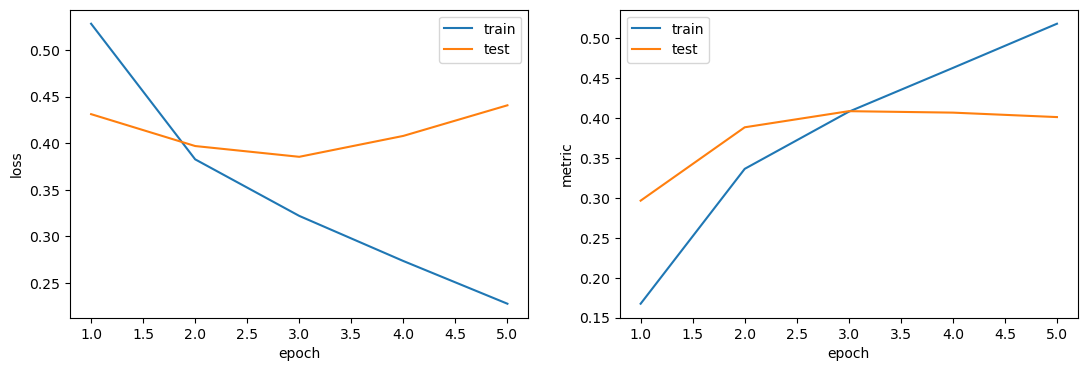

F1 on test: 0.40115030755361436


In [46]:
final_metric = train(train_loader, test_loader, num_epoch, optimizer, model)
# train_losses, test_losses, train_metrics, test_metrics = train(test_loader, test_loader, 1, optimizer, model)
print(f'F1 on test: {final_metric}')

## че-то старое

#### У Bert свой собсвенный токенайзер, который разбивает слова на мелкие токены, поэтому нам нужно корректно сопоставить токены и соответсвующие им неры.

In [ ]:
example = ner_train[1]
labels = example['tags']
metric.compute(predictions=[labels], references=[labels])

{'локация': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [ ]:
# что мы видим без дообучения модели
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=0)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }
# trainer = Trainer(
#     model,
#     args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["test"],
#     data_collator=data_collator,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )

# trainer.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
# import logging
# from transformers.trainer import logger as noisy_logger
# noisy_logger.setLevel(logging.WARNING)

In [ ]:
# # Для дообучения берта можно эксперементировать с заморозкой/разморозкой разных слоев, здесь мы оставим все слои размороженными
# # Для быстроты обучения можно заморозить всю бертовую часть, кроме классификатора, но тогда качесвто будет похуже
# for param in model.parameters():
#     param.requires_grad = True

In [ ]:
# args = TrainingArguments(
#     "ner",
#     evaluation_strategy = "epoch",
#     learning_rate=1e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=20,
#     weight_decay=0.01,
#     save_strategy='no',
#     report_to='none',
# )

In [ ]:
# trainer = Trainer(
#     model,
#     args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["test"],
#     data_collator=data_collator,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )

In [ ]:
# trainer.train()

In [ ]:
# trainer.evaluate()

In [ ]:
# Посчитаем метрики на отложенном датасете

predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
cm = pd.DataFrame(
    confusion_matrix(sum(true_labels, []), sum(true_predictions, []), labels=label_list),
    index=label_list,
    columns=label_list
)
cm

In [ ]:
model.save_pretrained('ner_bert.bin')
tokenizer.save_pretrained('ner_bert.bin')

### Посмотрим на результаты

In [ ]:
# text = ' '.join(ner_train[25]['tokens'])
text = ner_train[25]['tokens']

In [ ]:
import torch
from transformers import pipeline

pipe = pipeline(model=model, tokenizer=tokenizer, task='ner', aggregation_strategy='average', device='cpu')

def predict_ner(text, tokenizer, model, pipe, verbose=True):
    tokens = tokenizer(text, truncation=True, is_split_into_words=True, return_tensors='pt')
    tokens = {k: v.to(model.device) for k, v in tokens.items()}

    with torch.no_grad():
        pred = model(**tokens)
    # print(pred.logits.shape)
    indices = pred.logits.argmax(dim=-1)[0].cpu().numpy()
    token_text = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
    labels = []
    for t, idx in zip(token_text, indices):
        if '##' not in t:
            labels.append(label_list[idx])
        if verbose:
            print(f'{t:15s} {label_list[idx]:10s}')
    return text, pipe(text), labels

In [ ]:
predict_ner(text, tokenizer, model, pipe)

### Тестового датасета у вас пока нет, по которому будет считаться метрика на лидерборде, но прогоним для примера через нашу отложенную выборку, чтобы понять формат выходных данных.
ВАЖНО: в тестовом датасете у вас будет тест в том же формате, что он был в трейне 'video_info', в финальном сабмишене эту колонку и индексы менять нельзя, нужно будет только заполнить колонку 'entities_prediction'

In [ ]:
from tqdm.notebook import tqdm

submission = pd.DataFrame(columns=[['video_info', 'entities_prediction']])
submission['entities_prediction'] = submission['entities_prediction'].astype('object')
def sample_submission(text, tokenizer, model, pipe, submission):
    for i, elem in tqdm(enumerate(ner_test)):
        _, _, labels = predict_ner(elem['tokens'], tokenizer, model, pipe, verbose=False)
        submission.loc[i, 'video_info'] = elem

        submission.loc[i, 'entities_prediction'] = [[label] for label in labels]
    return submission

In [ ]:
result = sample_submission(text, tokenizer, model, pipe, submission)

In [ ]:
result

In [ ]:
len(ner_test)

### bert-base

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("yqelz/xml-roberta-large-ner-russian")
model = AutoModelForTokenClassification.from_pretrained("yqelz/xml-roberta-large-ner-russian")

In [ ]:
nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "Меня зовут Данил, я живу в Московской области"

ner_results = nlp(example)
print(ner_results)

[{'entity': 'B-PER', 'score': 0.9787707, 'index': 3, 'word': '▁Данил', 'start': 11, 'end': 16}, {'entity': 'B-LOC', 'score': 0.9992218, 'index': 9, 'word': '▁Московской', 'start': 27, 'end': 37}, {'entity': 'I-LOC', 'score': 0.99966025, 'index': 10, 'word': '▁области', 'start': 38, 'end': 45}]
